# INF 674 S1: Galton-Watson Process

## Céline Comte & Fabien Mathieu

### 2017-2018

To start the course, we propose to investigate the **Galton-Watson process**.
This process was introduced to depict the propagation of some feature (family surname, DNA) through generations, and in particular to estimate its probability of extinction.

A Galton-Watson process can be represented as a (directed) random tree. It is built generation by generation as follows. At generation $0$, there is a single individual, the ancestor of the population, represented by the tree *root*. Starting from this, each individual from a given generation $ i $ gives birth to a certain number of individual at generation $ i+1 $, represented by its direct successors in the tree.

The unique parameter of the process is the distribution of the number of children of each node. Specifically, we assume that the number of children of a node is independent from the other nodes, drawn according to some given distribution $(p_k)_{k\in \mathbb{N}}$ (s.t. $\sum_{k=0}^{\infty} p_k = 1$). We let $\mu$ denote the average number of children, supposed finite:
$$
\mu =  \sum_{k=0}^{\infty} k p_k <+\infty.
$$

Note that there are multiple ways to explore the tree. For example:
- **Generation by generation**: This is the view we presented above. We call $ G_i $ the random variable which counts the number of nodes at generation $ i $.
- **Active node by active node**: The nodes are visited one by one to decide on their number of offsprings. We keep track of the number of nodes which are *active* in the sense that we have discovered them but we have not drawn their number of offsprings yet. As long as there are active nodes, we can perform a *termination* which consists in desactivating a node, drawing the number of its children according to $(p_k)_{k \in \mathbb{N}}$ and adding these children (if any) to the set of active nodes. We call $ X_t $ the number of active nodes after $ t $ terminations, with the convention that $X_0 = 1$. Observe that $(X_t)_{t \in \mathbb{N}}$ defines a Markov process which is similar to a birth-and-death process, except that state $0$ is absorbing.

The goal of the practical is to play with the two views to understand Galton-Watson processes.

If you want to deepen your theoretical knowledge of this process, you can read Chapter 1 from the book [Epidemics and Rumours in Complex Networks][massoulie] (which is **not** mandatory).

[massoulie]: https://www.cambridge.org/core/books/epidemics-and-rumours-in-complex-networks/8C1D162F44C2C09F2B913038A7FA8BF6 "Epidemics and Rumours in Complex Networks by Moez Draief and Laurent Massoulié"

In [1]:
%pylab inline
import itertools,sys

Populating the interactive namespace from numpy and matplotlib


# 1. Bimodal distribution

We first assume a very simple children distribution, the *bimodal* distribution, where a node can only have 0 or 2 children: $p_0=1-\mu/2, p_2=\mu/2, p_k=0$ for $k\notin \{0,2\}$. In this section, we focus on values of the mean $\mu$ which range between $0$ and $2$, and perform an empirical study of the associated Galton-Watson process.

Note: Try to write a flexible code, as parameters and distributions will change.

## Question 1

We first consider the *generation by generation* exploration. Write a function ``generation_growth`` that returns the values $G_i$ observed during a realization of the process (up to generation ``imax``).

Run it a few times with different values of the mean $\mu$. Can you comment?

The function ``random.rand`` of ``numpy`` package may be handy.

**Code:**

In [2]:
def generation_growth(μ, imax = 20):
    """
    Produces one run of G_{0, imax}
    """
    g = zeros(imax + 1, dtype = int)
    g[0] = 1
    for i in range(imax): # You can't really avoid the loop since the computation uses recursion
        if g[i] == 0:
            break
        # g[i+1] = 2*binomial(g[i],μ/2,1)
        g[i+1] = 2 * sum(rand(g[i]) < μ/2)
    return g

In [3]:
def vec_generation_growth(μ, n=1, imax = 20):
    """
    Produces n runs of G_{0,imax}
    """
    g = zeros((imax + 1, n),dtype=int)
    g[0] = ones(n,dtype=int)
    for i in range(imax):
        if all(g[i] == 0):
            break
        g[i+1] = 2*binomial(g[i],μ/2)
    return (g)

**Discussion:**

$\mu$ is the average number of children per node. Since all the nodes are independant regarding the number of children, with $\mathbb{E}(G_{i+1}) = μ\mathbb{E}(G_{i})$, we expect a critical change of behaviour at $\mu=1$.

When $\mu<1$ the population tends to extinct, which is not the case when $\mu>1$.

In [4]:
μ = 1.
generation_growth(μ)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

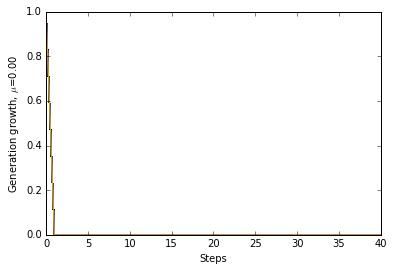

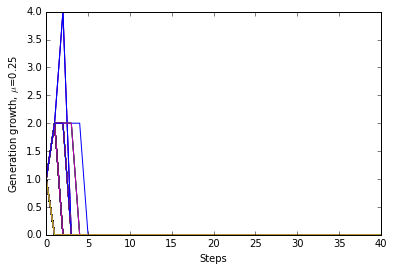

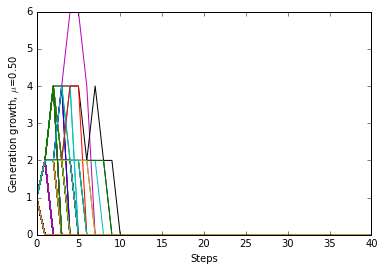

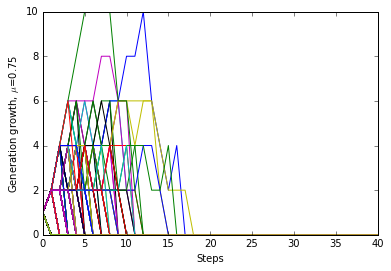

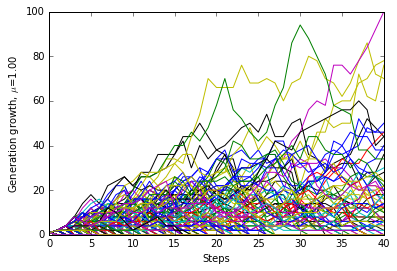

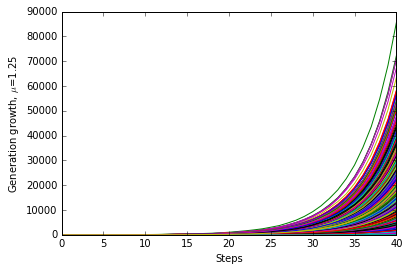

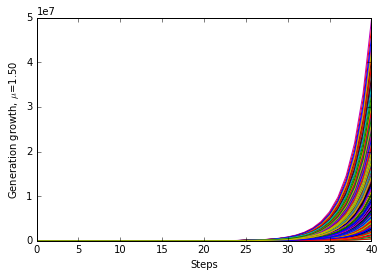

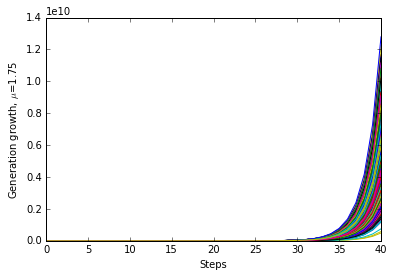

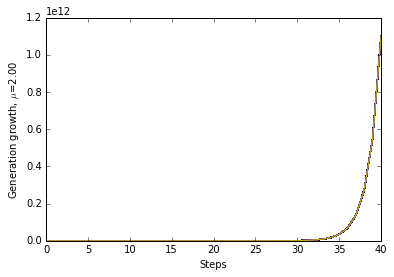

In [5]:
imax = 40   # Number of steps to display
ntst = 1000 # Number of runs to display
steps = list(range(imax+1))
for μ in arange(0.,2.1,0.25):
    """
    For each value of μ, display ntst runs until imax and see the different tendencies.
    """
    figure()
    plot(steps,vec_generation_growth(μ,ntst,imax=imax))
    xlabel('Steps')
    ylabel('Generation growth, $\mu$={:.2f}'.format(μ))
    show()

## Question 2

We now consider the *active node by active node* exploration. Write a function ``active_growth`` that returns the values $X_t$ observed during a realization of the process (fix a maximal number ``tmax`` of terminations). Warning: your function should not return negative values.

Run it a few times with different values of the mean $\mu$. Can you comment?

**Code:**

In [6]:
def active_growth_ext(μ, tmax = 20):
    """
    Active growth ignoring the fact that you can die.
    Will produce vectors with negative values but it
    is not important when you just want to know if
    the process ended.
    This works even if μ is a vector.
    """
    x = 2*(rand(tmax+1)<μ/2) - 1
    x[0] = 1
    return cumsum(x)

def active_growth(μ,tmax=20):
    """
    Simply corrects by removing the values after the
    first 0.
    """
    x = active_growth_ext(μ,tmax=tmax)
    x *= cumprod(x>0)
    return x

**Discussion:**

The same behaviour as with `generation_growth` can be observed.

In [7]:
μ = 1.
active_growth(μ)

array([1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Question 3

Write two functions ``estimate_generation`` and ``estimate_active`` that estimate  $\mathbb{E}(G_i)$ and $\mathbb{E}(X_t)$ by averaging the results over $ n $ runs.

For $\mu = 1/2$ and $\mu = 4/3$, display the results in figures and comment.

**Code: **

In [8]:
def estimate_generation(μ, imax = 10, n = 1000):
    g = zeros(imax+1)
    for _ in range(n):
        g += generation_growth(μ, imax = imax)
    return g / n

In [9]:
def estimate_active(μ, tmax = 100, n = 1000):
    x = zeros(tmax+1)
    for _ in range(n):
        x += active_growth(μ, tmax = tmax)
    return x / n

**Discussion:**

We expect $\mathbb{E}(G_i) = \mu^i$ and this has been shown before in this document.

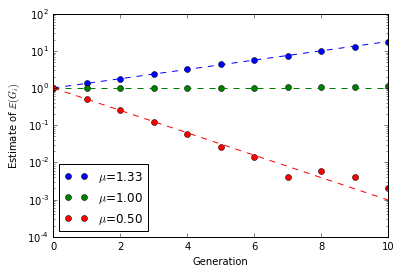

In [10]:
imax = 10

figure()
μ = 4/3
semilogy(arange(imax+1), estimate_generation(μ, imax), 'bo', label='$\mu$={:.2f}'.format(μ))
semilogy(arange(imax+1), μ**arange(imax+1), 'b--')
μ = 1
semilogy(arange(imax+1), estimate_generation(μ, imax), 'go', label='$\mu$={:.2f}'.format(μ))
semilogy(arange(imax+1), μ**arange(imax+1), 'g--')
μ = 1/2
semilogy(arange(imax+1), estimate_generation(μ, imax), 'ro', label='$\mu$={:.2f}'.format(μ))
semilogy(arange(imax+1), μ**arange(imax+1), 'r--')
xlabel('Generation')
ylabel('Estimate of $\mathbb{E}(G_i)$')
legend(loc=3)
show()

We expect (with an average of $\mu$ children per person) $\mathbb{E}(X_i)\approx 1+\mu i$ but only experimentally have $\mathbb{E}(X_i)\propto1+\mu i$.

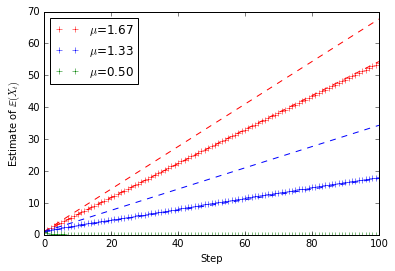

In [11]:
tmax = 100

figure()
μ=5/3
plot(arange(tmax+1), estimate_active(μ, tmax), 'r+', label='$\mu$={:.2f}'.format(μ))
plot(arange(tmax+1), 1 + (μ-1) * arange(tmax+1), 'r--')
plot(arange(tmax+1), 1 + 0.8*(μ-1) * arange(tmax+1), 'r--') # facteur correctif expérimental
μ=4/3
plot(arange(tmax+1), estimate_active(μ, tmax), 'b+', label='$\mu$={:.2f}'.format(μ))
plot(arange(tmax+1), 1 + (μ-1) * arange(tmax+1), 'b--')
plot(arange(tmax+1), 1 + 0.5*(μ-1) * arange(tmax+1), 'b--') # facteur correctif expérimental
μ=1/2
plot(arange(tmax+1), estimate_active(μ, tmax), 'g+', label='$\mu$={:.2f}'.format(μ))
xlabel('Step')
ylabel('Estimate of $\mathbb{E}(X_t)$')
legend(loc=2)
show()

## Question 4

At each realization, you may face extinction in the sense that none of the nodes of this generation has children. Write a function ``estimate_extinction`` that uses the function ``active_growth`` of Question 2 to estimate the probability of extinction $ P_{ext} $. Run it on a few values of $\mu$.

**Code:**

In [12]:
def estimate_extinction(μ, tmax = 20, n = 1000):
    """
    Simply use active growth and look if it reaches 0 at any point.
    """
    p = 0
    for i in range(n):
        p += any(active_growth_ext(μ,tmax=tmax) <= 0)
    return p/n

def vec_estimate_extinction(tmax=20,n=1000):
    """
    Creates a version accepting vectors, just to simplify
    the plot creation syntax.
    """
    @vectorize
    def ee(μ):
        p = 0
        for i in range(n):
            p+=(any(active_growth_ext(μ,tmax=tmax)<=0))
        return p/n
    return ee

In [13]:
μmax = 2.0
step = 0.02
tmax = 1000
n = 1000

μ = arange(0.0,μmax,step)
p = vec_estimate_extinction(tmax = tmax, n = n)(μ)

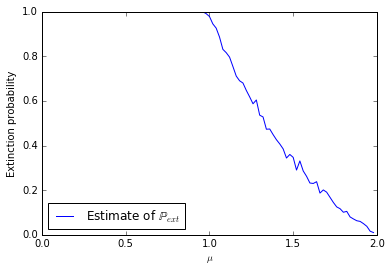

In [14]:
figure()
plot(μ, p, label='Estimate of $\mathbb{P}_{ext}$')
xlabel('$\mu$')
ylabel('Extinction probability')
legend(loc=3)
show()

## Question 5 (Bonus)

Evaluate $\mathbb{E}(G_i)$ conditioned on the run has lead to extinction or not. Discuss the results.

**Answer:**

# 2. Extinction

We focus now on the probability $P_{ext}$ of extinction, which is the probability that the total population is finite. We will observe experimentally the following phase transition:
- If $\mu < 1$, then $P_{ext} = 1$.
- If $\mu > 1$, then $P_{ext} < 1$.

The proof of this result is given in [Epidemics and Rumours in Complex Networks][massoulie], along with more details (in particular, the behavior of the process when $\mu = 1$).

[massoulie]: https://www.cambridge.org/core/books/epidemics-and-rumours-in-complex-networks/8C1D162F44C2C09F2B913038A7FA8BF6 "Epidemics and Rumours in Complex Networks by Moez Draief and Laurent Massoulié"

## Question 1

Give an equality that relates $P_{ext}$ and $(p_k)_{k\in \mathbb{N}}$.

**Answer:**

A Galtson-Watson process dies if an only if each and every one of his *independent* children processes dies. By conditioning on the number of children, we obtain

$$
\mathbb{P}_{ext} = \sum_{k=0}^{+\infty}{p_k\mathbb{P}_{ext}^k}
$$

## Question 2 

We consider the bimodal distribution of Exercise 1.
Admitting that $P_{ext}$ is the smallest solution of the previous equation in the interval $[0,1]$, relate $P_{ext}$ and $\mu$.
Write a (very) small function ``pext_bim_exact`` that computes $P_{ext}$ for a list of $\mu$'s.

**Answer:**

Considering the bimodal distribution, $P_{ext}$ is simply obtained by solving a quadratic equation.

$$
P_{ext} = \left\lbrace\begin{array}{ll}1 &\text{if }\mu=0\\\dfrac{1-\sqrt{1-\mu(2-\mu)}}\mu&\text{otherwise}\end{array}\right.
$$

In [15]:
"""
The function is slightly longer in order to be able to accept arrays.
"""
@vectorize
def divide(α,μ):
    if μ == 0.:
        return 1.
    else:
        return α/μ

def pext_bim_exact(μ):
    α = μ/2
    α = 1-sqrt(maximum(0.,1 - 4 * α * (1-α)))
    return divide(α,μ)

In [16]:
μ = arange(0.,2.,0.02)
data = pext_bim_exact(μ)

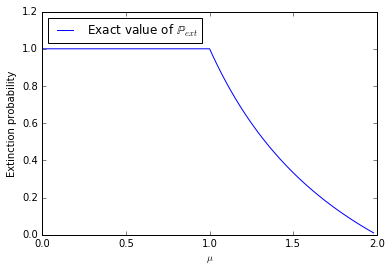

In [17]:
figure()
plot(μ, data, label='Exact value of $\mathbb{P}_{ext}$')
xlabel('$\mu$')
ylabel('Extinction probability')
legend(loc=2)
show()

## Question 3

Adapt the function from Question 4 of Exercice 1 to estimate $P_{ext}$ by simulation for multiple values of $\mu$. Suggested values: ``t=10``, ``t=100``, ``t=1000``, ``n=1000``, $\mu$ ``= np.arange(0,2.05,.05)``. Display the results you obtain against the theoretical value obtained in the previous question. Discuss the difference.

**Code:**

In [18]:
μ = arange(0.,2.,0.02)
data = dict()
nrun=1000
for i in [10,100,1000]:
    data[i] = vec_estimate_extinction(tmax=i,n=nrun)(μ)
exact = pext_bim_exact(μ)

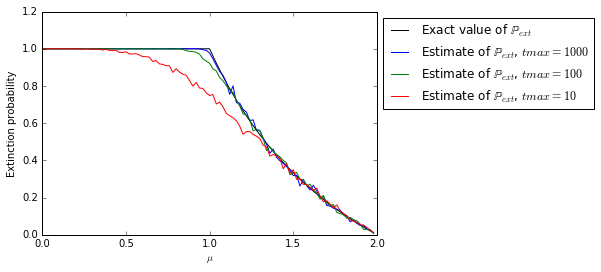

In [19]:
figure()
plot(μ, exact, 'k-', label='Exact value of $\mathbb{P}_{ext}$')
for x in sorted(data,reverse=1):
    plot(μ, data[x], label='Estimate of $\mathbb{{P}}_{{ext}}$, $tmax={:d}$'.format(x))
xlabel('$\mu$')
ylabel('Extinction probability')
legend(loc=2,bbox_to_anchor=(1, 1))
show()

**Discussion:**

The estimate we provide is not exactly an *estimate* of the extinction probability (i.e. determined with a finite number of experiment runs), it is more specifically an estimate of the probability for a process to die *before* a certain $tmax$. This probability is obviously increasing when $tmax$ increases, and gets closer to $\mathbb{P}_{ext}$ when $tmax\rightarrow+\infty$.

## Question 4

Evaluating the results by simulation has an inherent lack of accuracy. Try to compute exactly the probability that all nodes are dead after $t$ terminations. Display the results and compare.

Hint: for $t <\infty$, write a function ``pop_after_t`` that computes the **distribution** of the number of active nodes after $t$ terminations as a function of $ p = (p_k)_{k \in \mathbb{N}}$. The function ``convolve`` from ``numpy`` package may be handy.

**Answer:**

$$\left\lbrace\begin{array}{ll}
\mathbb{P}(X_{t+1} = n) = \sum_{k=0}^{n}{p_k\mathbb{P}(X_t = n+1 - k)} & \text{if }n>0 \\
\mathbb{P}(X_{t+1} = 0) = p_0\mathbb{P}(X_t = 1) + \mathbb{P}(X_t = 0)
\end{array}\right.$$

**Code:**

In [20]:
def pop_after_t(p,trunc=False):
    """
    Returns a function of t that will return the distribution
    of the number of active nodes after t terminations.
    """
    memo = dict()
    memo[0] = asarray([0,1],dtype=float)
    def pop_after(t):
        if t in memo:
            return memo[t]
        d = pop_after(t-1)
        x = convolve(p,d[1:])
        x[0]+=d[0]
        if trunc:
            x = x[:trunc]
            x[-1] += 1. - sum(x)
        memo[t] = x
        return x
    return pop_after

def extinct_after_t(p):
    """
    Returns a function that gives the probability to be extinct
    after t terminations.
    """
    pa = pop_after_t(p)
    def extinct_after(t):
        return pa(t)[0]
    return extinct_after

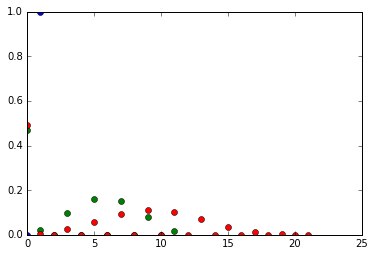

In [21]:
μ = 4/3
α = μ/2
p = asarray([1-α,0,α],dtype=float)
pa = pop_after_t(p)

figure()
plot(pa(0),'bo',label='t=0')
plot(pa(10),'go',label='t=10')
plot(pa(20),'ro',label='t=20')
show()

In [22]:
sys.setrecursionlimit(2000)

def bimodal_extinct_after(tmax=20):
    @vectorize
    def aux(μ):
        p = asarray([1-μ/2,0,μ/2],dtype=float)
        return extinct_after_t(p)(tmax)
    return aux

In [23]:
μ = arange(0.,2.,0.02)
n = [10,100,1000]
nrun = 1000
c = ['r','g','b']

In [24]:
exact = dict()
for i in sorted(n):
    exact[i] = bimodal_extinct_after(tmax=i)(μ)

In [25]:
estim = dict()
for i in sorted(n):
    estim[i] = vec_estimate_extinction(tmax=i,n=nrun)(μ)

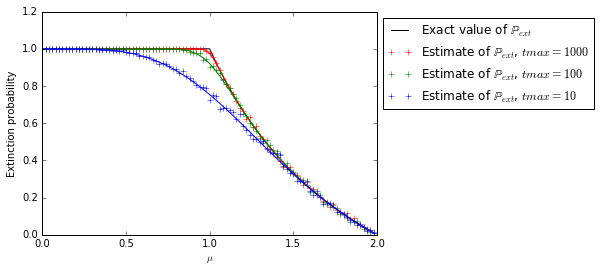

In [26]:
figure()
plot(μ, pext_bim_exact(μ), 'k-', label='Exact value of $\mathbb{P}_{ext}$')
for i,k in enumerate(sorted(n,reverse=True)):
    plot(μ, exact[k], '{:}-'.format(c[i]))
    plot(μ, estim[k], '{:}+'.format(c[i]), label='Estimate of $\mathbb{{P}}_{{ext}}$, $tmax={:d}$'.format(k))
xlabel('$\mu$')
ylabel('Extinction probability')
legend(loc=2,bbox_to_anchor=(1, 1))
show()

# 3. Other Distributions 

## Question 1 

We now consider a geometric distribution $p_k=(1-a)a^k$, or each $k \in \mathbb{N}$, for some $0\leq a<1$. Relate $a$ and $\mu$ and study the extinction probability like you did for the bimodal case. In particular, give the equation $ P_{ext} $ should verify. Compute $ P_{ext} $ as a function of $ \mu $ for $ \mu\in [0, 2] $. For the non trivial cases, you can use an iterative computation of the solution. To validate the result, you should for instance:
- Adapt ``pop_after_t`` to compute $ P_{ext} $ after ``t=1000`` terminations for a truncated geometric distribution.
- Run multiple simulations using a geometric generator. The function ``random.geometric`` from ``numpy`` package may be handy.

Display the results.

$$\mathbb{P}_{ext} = \sum_k{p_k\mathbb{P}_{ext}^k} = (1-a)\sum_k{(a\mathbb{P}_{ext})^k} = \frac{1-a}{1-a\mathbb{P}_{ext}}$$

$$\mathbb{P}_{ext} = \frac{1-\sqrt{1-4a(1-a)}}{2a}\text{is defined when }a>0\text{. When }a=0\text{, }\mathbb{P}_{ext}=1$$

**Code:** 

In [27]:
def pext_geo_exact(a):
    # return pext_bim_exact(2*a) # could do that but more operations
    α = 1-sqrt(maximum(0.,1 - 4 * a * (1-a)))
    return divide(α,2*a)

def geo_distr(a,trunc=100):
    p = a * ones(trunc,dtype=float)
    p[0] = 1.
    p = cumprod(p)
    p*=(1.-a)
    p[-1]+=1. - sum(p) # correction for 'a' close to 1
                       # Note: if you remove this line,
                       # graphs for a>=0.99 are really
                       # unrealistic
    return p

def geo_pop_after_t(a,trunc=100):
    return pop_after_t(geo_distr(a,trunc=trunc),trunc=False)

def geometric_extinct_after(tmax=20,trunc=100):
    @vectorize
    def aux(a):
        p = geo_distr(a,trunc=trunc)
        return extinct_after_t(p)(tmax)
    return aux

In [28]:
# reset memoization
n=1000
gpa=dict()

In [29]:
def plot_data_multi(xlist,a=None,b=None):
    figure()
    for x in xlist:
        if not x in gpa:
            gpa[x] = geo_pop_after_t(x)(n)
        data = gpa[x]
        xval = list(range(len(data)))
        data = data[a:b]
        xval = xval[a:b]
        plot(xval,100*data,label='a={:.3f}, covers {:.2f}%'.format(x,100.*sum(data)))
    legend(loc=2,bbox_to_anchor=(1,1))
    xlabel('Size of population after {:d} terminations.'.format(n))
    ylabel('Percentage')
    show()

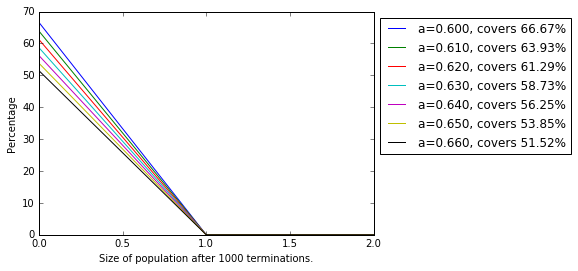

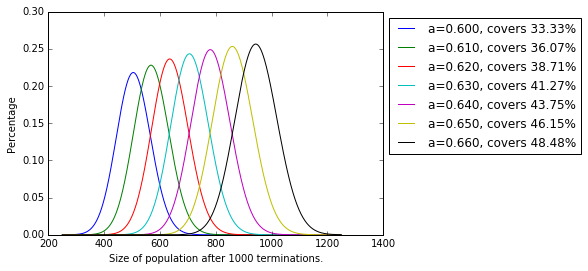

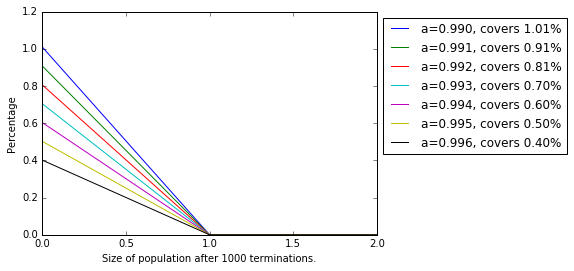

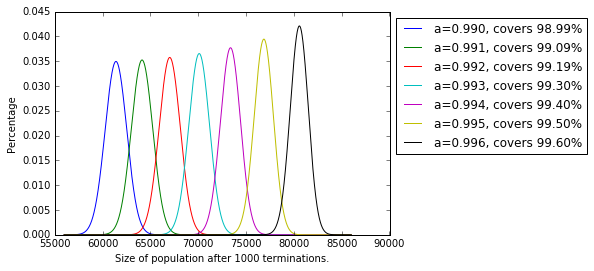

In [30]:
if 1: # really slow to compute when memoization has been reset
    x=arange(0.6,0.66,0.01)
    plot_data_multi(x,b=3)
    plot_data_multi(x,a=250,b=1250)

if 1: # really slow to compute when memoization has been reset
    x = arange(0.99,0.996,0.001)
    plot_data_multi(x,b=3)
    plot_data_multi(x,a=56000,b=86000)

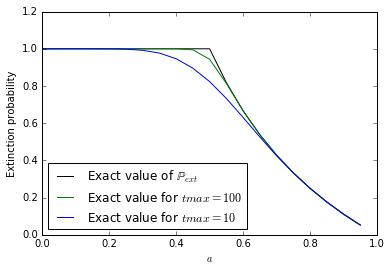

In [31]:
a = arange(0.,1.,0.05)

figure()
plot(a, pext_geo_exact(a), 'k-', label='Exact value of $\mathbb{P}_{ext}$')
plot(a, geometric_extinct_after(tmax=100)(a), 'g-', label='Exact value for $tmax=100$')
plot(a, geometric_extinct_after(tmax=10)(a), 'b-', label='Exact value for $tmax=10$')
xlabel('$a$')
ylabel('Extinction probability')
legend(loc=3)
show()

## Question 2

We finally consider a Poisson distribution of parameter $\mu$:
$$
    p_k = e^{-\mu}\frac{\mu^k}{k!},
    \quad \forall k \in \mathbb{N}.
$$
Study the extinction probability.
In particular, give the equation $ P_{ext} $ should verify. Compute $ P_{ext} $ as a function of $ \mu $ for $ \mu\in [0, 2] $. For the non trivial cases, you can use an iterative computation of the solution. To validate the result:
- Adapt ``pop_after_t`` to compute $ P_{ext} $ after ``t=1000`` terminations for a truncated Poisson distribution.
- Run multiple simulations using a Poisson generator. The function ``random.poisson`` from ``numpy`` package may be handy.

Display the results.

$$\mathbb{P}_{ext} = \sum_k{p_k\mathbb{P}_{ext}^k} = e^{-\mu}\sum_k{\frac{(\mu\mathbb{P}_{ext})^k}{k!}} = e^{\mu \mathbb{P}_{ext}-\mu}$$

**Code:**

## Question 3 (Bonus) 

Plot the three theoretical $ P_{ext} $ you obtained on the same figure, for the same mean value $\mu$. Try to informally discuss the differences.

**Answer:**

## Question 4 (Bonus)

Redo the exercices of this Notebook for a Galton-Watson process that starts with two nodes (you can re-use results from above).